# Analysis of mondal2023cell2doc

In this notebook we analyse the data collected from the Cell2Doc dataset.

In [145]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

sns.set_theme(context="talk", style="whitegrid", palette="colorblind")

In [2]:
stats = pd.read_csv(
    "data/shome2023notebook/mondal2023cell2doc-stats.csv",
    header=None,
    names=["notebook", "num_code_cells", "num_md_cells", "num_assert_cells"],
)
assert_content = pd.read_csv(
    "data/shome2023notebook/mondal2023cell2doc-assert-content.csv",
    header=None,
    names=["cell_type", "source", "notebook"],
)

# Descriptive statistics of notebooks with assertions

In this section we compute some high-level descriptive statistics of notebooks that contain assertions.

We use the following terminology thoughout the analysis:
1. Code cell: cells with `cell_type` 'code'
2. Markdown (md) cell: cells with `cell_type` 'markdown'
3. Test cell: cells that contain at least 1 test. We consider all tests that may be written using the python `assert` keyword or a a function provided by an external testing library (eg. python `unittest`, `numpy.testing`, etc). The reasoning here is that popular testing libraries provide test methods with names containing the keyword "assert" in them.
3. Assert cell: code cells that contain at least 1 node of type `ast.Assert`

We compute the following statistics:
1. What is the average number of code cells, markdown cells and assert cells in a notebook?
1. What is the ratio of code cells with vs. without assertions?

In [3]:
stats.loc[:, "code_cells_wo_assert"] = (
    stats.loc[:, "num_code_cells"] - stats.loc[:, "num_assert_cells"]
)
stats.describe()

,num_code_cells,num_md_cells,num_assert_cells,code_cells_wo_assert
count,521.000000,521.000000,521.000000,521.000000
mean,23.863724,13.190019,1.358925,22.504798
std,20.184025,15.614970,0.803695,20.035557
min,1.000000,0.000000,1.000000,0.000000
25%,12.000000,3.000000,1.000000,11.000000
50%,19.000000,9.000000,1.000000,18.000000
75%,31.000000,17.000000,1.000000,29.000000
max,249.000000,151.000000,6.000000,248.000000


<Axes: >

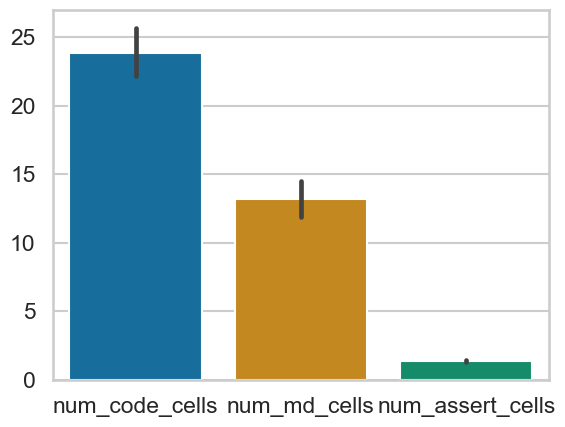

In [4]:
sns.barplot(data=stats.loc[:, ["num_code_cells", "num_md_cells", "num_assert_cells"]])

<Axes: >

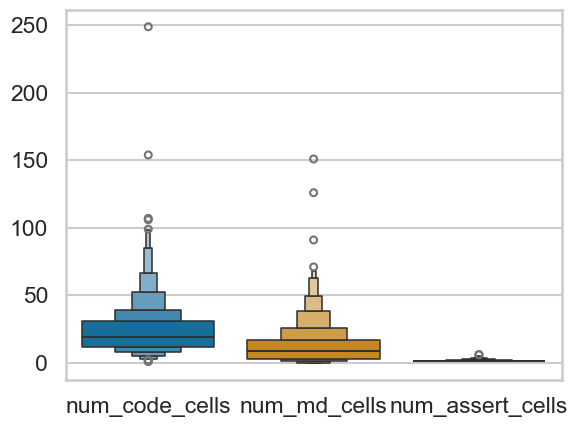

In [5]:
# TODO: stretch the boxplots more
sns.boxenplot(data=stats.loc[:, ["num_code_cells", "num_md_cells", "num_assert_cells"]])

We observe that in our population of notebooks, the number of code cells is more than the number of markdown cells. This is (probably) in line with the observations from [@quaranta2021kgtorrent].

On average, a notebook contains ~21 code cells but only ~1 

# Data pre-processing

Lets convert the raw source code into a AST and add it to the dataframe under the `ast` column.

For cells with invalid source code, we fill the `ast` column with NaN.

In [6]:
assert_content.head()

,cell_type,source,notebook
10,code,"test_blocks = [\n list(range(0, 100000)) + ...",data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...
45,code,class InferenceConfig(FashionConfig):\n GPU...,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...
6,code,"""""""\nVector-Quantization for the VQ-VAE itself...",data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...
7,code,"""""""\nAn implementation of the hierarchical VQ-...",data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...
8,code,import numpy as np\nimport torch\n\n# from .vq...,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...


In [7]:
def get_ast(source: str) -> ast.Module:
    try:
        tree = ast.parse(source)
    except SyntaxError:
        tree = np.nan
    finally:
        return tree


assert_content.loc[:, "ast"] = assert_content["source"].apply(get_ast)

<unknown>:13: SyntaxWarning: invalid escape sequence '\s'
<unknown>:415: SyntaxWarning: invalid escape sequence '\['
<unknown>:64: SyntaxWarning: invalid escape sequence '\w'
<unknown>:92: SyntaxWarning: invalid escape sequence '\w'
<unknown>:105: SyntaxWarning: invalid escape sequence '\s'
<unknown>:60: SyntaxWarning: invalid escape sequence '\w'


In [8]:
def get_error(source: str) -> str:
    try:
        ast.parse(source)
    except SyntaxError as err:
        return err


invalid = assert_content.loc[assert_content["ast"].isna()]
invalid.loc[:, "error"] = invalid.loc[:, "source"].apply(get_error)
invalid["error"]

/var/folders/3_/dh2k952n2rld3_w3r369mln80000gn/T/ipykernel_1319/208890765.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid.loc[:, "error"] = invalid.loc[:, "source"].apply(get_error)


2     unterminated string literal (detected at line ...
1                    invalid syntax (<unknown>, line 1)
10                unexpected indent (<unknown>, line 1)
1                    invalid syntax (<unknown>, line 2)
7                   invalid syntax (<unknown>, line 13)
8                   invalid syntax (<unknown>, line 14)
5                   invalid syntax (<unknown>, line 28)
1     unterminated string literal (detected at line ...
15                   invalid syntax (<unknown>, line 1)
17                   invalid syntax (<unknown>, line 1)
21                   invalid syntax (<unknown>, line 1)
23                   invalid syntax (<unknown>, line 1)
1     unterminated string literal (detected at line ...
1                    invalid syntax (<unknown>, line 1)
6                    invalid syntax (<unknown>, line 1)
14                   invalid syntax (<unknown>, line 1)
0                   invalid syntax (<unknown>, line 51)
4                    invalid syntax (<unknown>, 

Most of the syntax errors are due to "unknown" nodes in the tree. Lets investigate a random sample of (source,error) to understand the problem.

In [9]:
for row in invalid.sample(5).itertuples():
    print("============================================================")
    print(f"NOTEBOOK:{row.notebook}")
    print("SOURCE:\n")
    print(f"{row.source}")
    print("ERROR:\n")
    print(f"{row.error}")
    print("============================================================")

NOTEBOOK:data/mondal2023cell2doc/Cell2Doc-Artifacts/Repository/notebooks-dataset/notebooks/golubev_c-stochastic-product-search-65ns.ipynb
SOURCE:

%%writefile main.cpp
#include <array>
#include <cassert>
#include <algorithm>
#include <cmath>
#include <fstream>
#include <iostream>
#include <vector>
#include <thread>
#include <random>
using namespace std;
#include <chrono>
using namespace std::chrono;

constexpr array<uint8_t, 14> DISTRIBUTION{2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 5}; // You can setup how many families you need for swaps and what best choice use for each family
// {2, 5} it's mean the first random family will brute force for choices 1-2 and the second random family will brute force for choices 1-5

constexpr int MAX_OCCUPANCY = 300;
constexpr int MIN_OCCUPANCY = 125;
constexpr int BEST_N = 1000;
array<uint8_t, 5000> n_people;
array<array<uint8_t, 10>, 5000> choices;
array<array<uint16_t, 10>, 5000> PCOSTM;
array<array<double, 176>, 176> ACOSTM;

void init_data() {
    i

TODO: Python AST module does not know about ipython's magic & very magic syntax. Let's remove these cells for now. However ideally we should just remove the (very)magic lines from the `source`.

In [10]:
assert_content = assert_content.loc[
    assert_content["ast"].notna(), ["cell_type", "source", "ast"]
]
assert_content.shape

(685, 3)

Lets also remove all cells where are are no top level nodes. This can occur when the `source` is entirely commented out.

In [11]:
def get_top_nodes(tree):
    return [node for node in ast.iter_child_nodes(tree)]


assert_content.loc[:, "top_nodes"] = assert_content.loc[:, "ast"].apply(get_top_nodes)
assert_content = assert_content.loc[
    ~assert_content["top_nodes"].apply(lambda x: len(x) < 1)
]
assert_content.shape

(684, 4)

# Anatomy of assert cells (content)

In this section we analyse the contents of assert cells.

In the data collection phase (see bin/data-collection.py script for more details) we flagged any code cells that contain the `assert` keyword. This may lead to false positive results (for instance, the keyword appears in a comment or in the name of a function call).

Thus the first order of business is to remove such false positive results from our analysis. We can do this by constructing an AST (Abstract Syntax Tree) for the code cells. Actual `assert` statements will then appear as an `ast.Assert` node in the tree.

We are interested in the following:
1. How many number of top-level nodes are present in assert cells?
1. How many assert statements are typically present in the code cells?
2. Are assert statements usually written as a standalone test? Or are they defined within function calls?
3. Are assert statements defined in dedicated "test" cells? Or are they mixed in with code performing other tasks?

Similar to `top_nodes` column which we added in the prior section, lets add the assert nodes under the `assert_nodes` column.

In [12]:
def get_assert_nodes(tree: ast.Module) -> list[ast.Assert | float]:
    nodes = [node for node in ast.walk(tree) if isinstance(node, ast.Assert)]
    if not nodes:
        nodes = np.nan  # replace empty lists with NaN
    return nodes


assert_content.loc[:, "assert_nodes"] = assert_content.loc[:, "ast"].apply(
    get_assert_nodes
)

## Analysis of test cells without `Assert` node

In this section we analyse the test cells that did not contain any `Assert` node.

This means that the keyword `assert` appeared somewhere in the source code.

It is likely that these cells use an external testing library (such as `numpy.testing`).

NOTE: assuming that here an external framework is being used, the most likely node will be a `Call` object. We can extract the name of the function with the `Call.func` attribute which will either be a `Name` or `Attribute` object.

In [13]:
no_assert_cells = assert_content.loc[assert_content["assert_nodes"].isna()]
no_assert_cells.shape

(35, 5)

### Most frequent method names

Here we want to extract the name of the function with the keyword `assert`.

There are two cases to address when parsing the AST:
1. if its a direct method call, then the `Call.func` node will contain a `Name` node
2. if its a nested function call (ie. the module name(s) precede the function name) then the AST will be nested `Attribute` nodes. The function name will be at `Attribute.attr`.

In [67]:
class FunctionNameCollector(ast.NodeVisitor):
    def __init__(self):
        self.names = []

    def visit_Name(self, node):
        self.names.append(node.id)
        # we don't need to visit child nodes

    def visit_Attribute(self, node):
        self.names.append(node.attr)
        # NOTE: we don't need to visit child nodes since the top most Attribute.attr will contain the actual function name

In [128]:
def get_modfunc_name(node, stack):
    if isinstance(node, ast.Name):
        if stack:
            return (node.id, stack[0].attr)
        else:
            return (None, node.id)

    if isinstance(node, ast.Attribute):
        stack.append(node)
        return get_modfunc_name(node.value, stack)


In [129]:
call_nodes = no_assert_cells["ast"].apply(
    lambda x: [node for node in ast.walk(x) if isinstance(node, ast.Call)]
)
call_nodes = call_nodes.explode().dropna()

visitor = FunctionNameCollector()
call_nodes.apply(lambda x: visitor.visit(x))
visitor.names

names = []
for _, node in call_nodes.items():
    names.append(get_modfunc_name(node=node.func, stack=[]))

names = list(filter(lambda x: x, names))
names = pd.DataFrame(data=names, columns=["module", "function"])
names.head()

,module,function
0,np,assert_array_equal
1,data,groupby
2,None,range
3,None,range
4,layers,add


In [130]:
names.loc[names["function"].str.contains("assert")]

,module,function
0,np,assert_array_equal
66,None,assert_series_equal
67,None,assert_series_equal
68,None,assert_series_equal
377,tf,assert_equal
384,np,assert_array_less
385,np,assert_array_less
750,np,assert_array_equal


<Axes: xlabel='count', ylabel='function'>

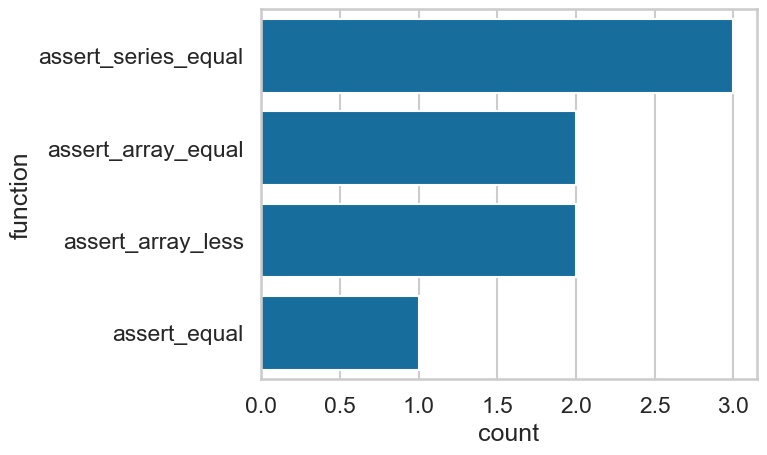

In [131]:
# NOTE: show the most popular functions
functions = names.loc[names["function"].str.contains("assert"), "function"]
sns.barplot(
    data=functions
    .value_counts()
    .sort_values(ascending=False),
    orient="h",
)

<Axes: xlabel='count', ylabel='module'>

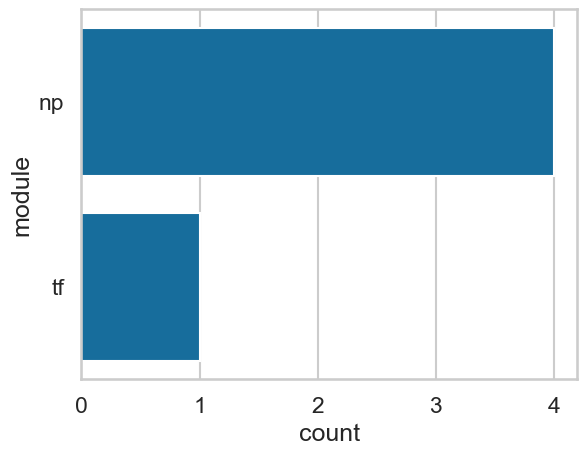

In [132]:
# NOTE: show the most popular apis (modules)
functions = names.loc[names["function"].str.contains("assert"), "module"]
sns.barplot(
    data=functions
    .value_counts()
    .sort_values(ascending=False),
    orient="h",
)

## Analysis of `Assert` nodes

In this section we analyse the `Assert` nodes in more detail. Some things to look into:

+ [X] What is the most common `Assert.test` node?
+ [X] Do assertions typically have a failure message? (`Assert.msg`)

In [16]:
assert_cells = assert_content.loc[assert_content["assert_nodes"].notna()]
assert_cells.shape

(649, 5)

[Text(0, 0, '929'),
 Text(0, 0, '120'),
 Text(0, 0, '40'),
 Text(0, 0, '22'),
 Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

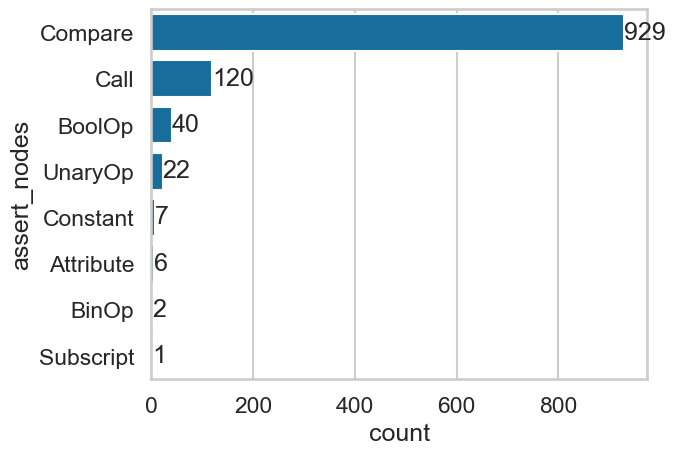

In [17]:
def count_nodes(nodes):
    return (
        nodes.apply(lambda x: x.__class__.__name__)
        .value_counts()
        .sort_values(ascending=False)
    )


asserts = assert_cells["assert_nodes"].explode()
tests = asserts.apply(lambda x: x.test)
ax = sns.barplot(data=count_nodes(tests), orient="h")
ax.bar_label(ax.containers[0])

Lets analyse the message nodes next.

In [133]:
msgs = asserts.apply(lambda x: x.msg).dropna()
print(f"total # tests: {len(asserts)}")
print(f"tests with failure message: {len(msgs.dropna())}")
print(f"tests without failure message: {len(asserts) - len(msgs.dropna())}")

total # tests: 1127
tests with failure message: 218
tests without failure message: 909


Very few assertions contain a failure message.

Text(0, 0.5, 'msg nodes')

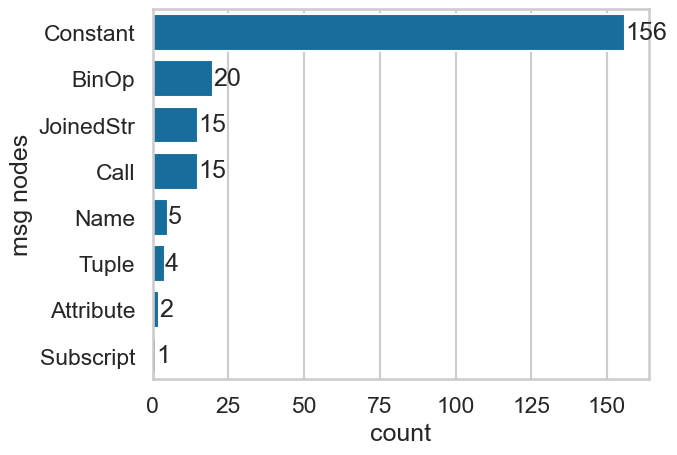

In [134]:
ax = sns.barplot(data=count_nodes(msgs), orient="h")
ax.bar_label(ax.containers[0])
ax.set_ylabel("msg nodes")

Most of the nodes under `Assert.msg` node are a constant, which is to be expected as the failure message is generally a string. Lets analyse these more to understand the motivation of the asserts.

(-0.5, 1499.5, 899.5, -0.5)

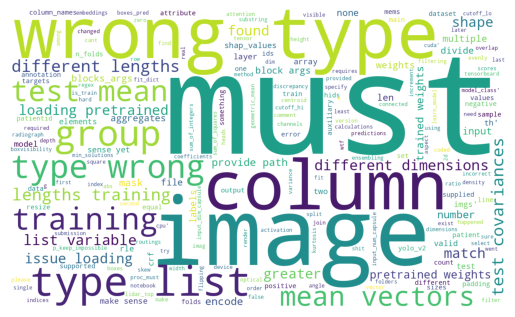

In [149]:
constants = msgs.loc[msgs.apply(lambda x: isinstance(x, ast.Constant))]
constants = constants.apply(lambda x: x.value)

corpus = ' '.join(constants.to_list()).lower()
wordcloud = WordCloud(width=750, height=450, background_color="white", stopwords=None, scale=2., collocations=True).generate(corpus)
plt.imshow(wordcloud)
plt.axis('off')

## Analysis of `Compare` nodes

Most of the tests in the assertions have a `Compare` node. We can ask the following questions here:

+ [X] What is the most common left? (`Compare.left`)
+ [X] What are the most common ops used? (`Compare.ops`)
+ [X] What are the most common comparators used? (`Compare.comparators`)
+ [X] Do we have assertions where multiple ops/comparators are used? (eg. `assert a < 2 >= b`)

Some additional things we can analyse:
+ [ ] Second most frequent node is `Call`, what are the functions being called here?

In [21]:
compares = tests.loc[
    tests.apply(lambda x: isinstance(x, ast.Compare))
]
compares.shape

(929,)

Lets observe a random sample of compare nodes to get a sense of the type of tests we are dealing with.

In [22]:
# NOTE: I think we need to revisit the source of notebooks, we have asserts that don't look related to ML
for _, node in compares.sample(10).items():
    print(ast.unparse(node))


len(rater_a) == len(rater_b)
len(glove1) == len(glove2)
calculate_iou(box1, box2, form='coco') == 0.0
len(set(dev_groups) & set(val_groups)) == 0
num_classes == self.num_classes
point - point == Point(0, 0)
len(column_names) == 2
type(column_names[1]) == str
len(input_shape) == 3
trn_series.name == tst_series.name


In [23]:
compare_content = pd.DataFrame(
    data={
        "left": compares.apply(lambda x: x.left),
        "ops": compares.apply(lambda x: x.ops),
        "comparators": compares.apply(lambda x: x.comparators),
    }
)
compare_content.head()

,left,ops,comparators
10,<ast.Call object at 0x126fc6290>,[<ast.Eq object at 0x1092d0750>],[<ast.Constant object at 0x126fc5c90>]
45,<ast.Name object at 0x126fc4590>,[<ast.NotEq object at 0x1092d07d0>],[<ast.Constant object at 0x126fc4450>]
6,<ast.Attribute object at 0x126fdd650>,[<ast.IsNot object at 0x1092d0ad0>],[<ast.Constant object at 0x126fdd810>]
7,<ast.Call object at 0x126fff110>,[<ast.Eq object at 0x1092d0750>],[<ast.Constant object at 0x126ffed90>]
7,<ast.Call object at 0x1270266d0>,[<ast.Eq object at 0x1092d0750>],[<ast.Constant object at 0x127026990>]


### Analysis of `Compare.left`


[Text(0, 0, '437'),
 Text(0, 0, '181'),
 Text(0, 0, '128'),
 Text(0, 0, '122'),
 Text(0, 0, '47'),
 Text(0, 0, '10'),
 Text(0, 0, '3'),
 Text(0, 0, '1')]

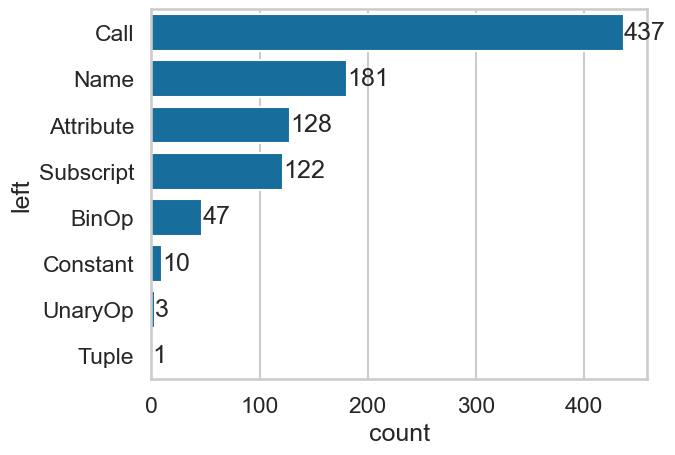

In [24]:
ax = sns.barplot(data=count_nodes(compare_content["left"]), orient="h")
ax.bar_label(ax.containers[0])


The most common LHS in the `Compare` nodes is a function call, followed by a `Name` and `Attribute` nodes.

Lets analyse the `Call`, `Name` and `Attribute` nodes in more detail.

+ [ ] what functions are being called here?
+ [ ] what names and attributes are being called here?

In [25]:
calls = compare_content["left"].loc[
    compare_content["left"].apply(lambda x: isinstance(x, ast.Call))
]


In [26]:
# NOTE: random sample of call nodes
for _, node in calls.sample(10).items():
    print(ast.unparse(node))

len(boxes)
len(input_shape)
len(item_data)
len(np.intersect1d(train_index, valid_index))
res.dim()
len(weights)
len(train_df[train_df['videoname'].isin(val_df['videoname'])])
len(set(train_idxs).intersection(set(valid_idxs)))
len(trn_series)
type(max_depth)


<Axes: xlabel='count'>

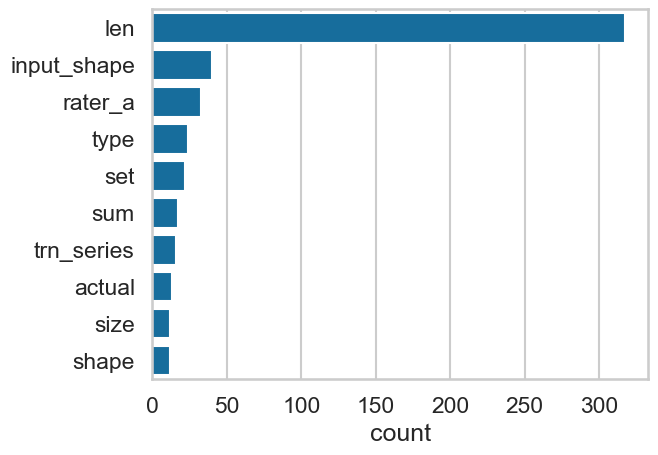

In [27]:
visitor = FunctionNameCollector()
calls.apply(lambda x: visitor.visit(x))

sns.barplot(
    data=pd.Series(data=visitor.names).value_counts().sort_values(ascending=False).head(n=10), orient="h"
)

The most common function call in the LHS of the compare nodes is `len`. This aligns with our observations during the manual analysis of Github notebooks!

### Analysis of `Compare.ops`

[Text(0, 0, '721'),
 Text(0, 0, '61'),
 Text(0, 0, '39'),
 Text(0, 0, '34'),
 Text(0, 0, '29'),
 Text(0, 0, '23'),
 Text(0, 0, '21'),
 Text(0, 0, '16'),
 Text(0, 0, '10')]

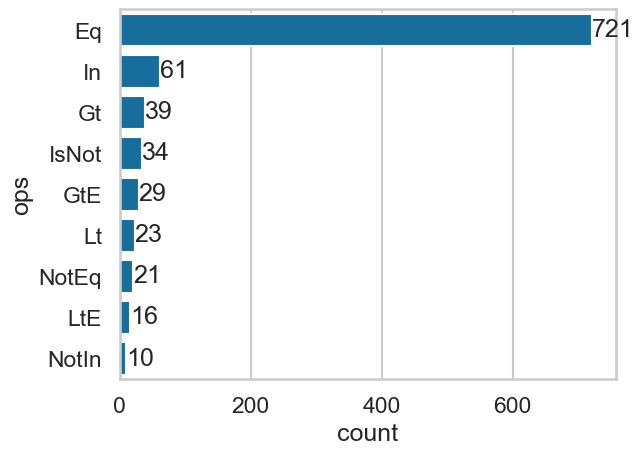

In [28]:
ops = compare_content["ops"].explode()
ax = sns.barplot(data=count_nodes(ops), orient="h")
ax.bar_label(ax.containers[0])

`==` is the most common operator used in the compare nodes.

### Analysis of `Compare.comparators`

Text(0, 0.5, 'right')

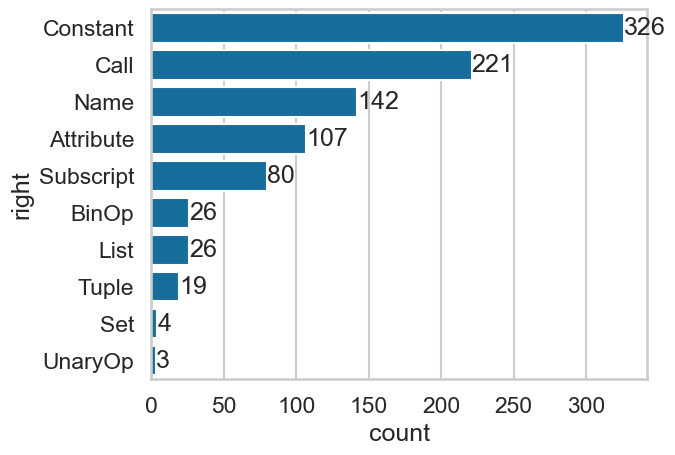

In [29]:
comparators = compare_content["comparators"].explode()
ax = sns.barplot(data=count_nodes(comparators), orient="h")
ax.bar_label(ax.containers[0])
ax.set_ylabel("right")

In [ ]:
(len) == 1

The most frequent RHS in the compare node is a `Constant`.

In [30]:
multi_ops = compare_content.loc[compare_content["ops"].apply(lambda x: len(x) > 1)]
multi_ops

,left,ops,comparators
18,<ast.Call object at 0x127196450>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.BinOp object at 0x127196110>, <ast.Const..."
7,<ast.Subscript object at 0x1276f4210>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.Subscript object at 0x1276fc190>, <ast.S..."
40,<ast.Call object at 0x1281475d0>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.Call object at 0x128147210>, <ast.Call o..."
6,<ast.Subscript object at 0x128ca4b10>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.Subscript object at 0x128ca4850>, <ast.S..."
42,<ast.Call object at 0x129463410>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.Call object at 0x129463050>, <ast.Call o..."
28,<ast.Subscript object at 0x129670450>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.Subscript object at 0x129670710>, <ast.S..."
29,<ast.Attribute object at 0x129865d50>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.Attribute object at 0x12986c1d0>, <ast.A..."
29,<ast.Call object at 0x12986cc10>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.Call object at 0x12986ced0>, <ast.Call o..."
55,<ast.Call object at 0x1298ab6d0>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.Call object at 0x1298ab310>, <ast.Call o..."
4,<ast.Subscript object at 0x12a6a1010>,"[<ast.Eq object at 0x1092d0750>, <ast.Eq objec...","[<ast.Subscript object at 0x12a6a0d50>, <ast.S..."


In [31]:
multi_ops.shape


(20, 3)

We have 20 examples where more than 1 ops was used.

# Context of assert cells

In this section we focus 